### 02 — Modelling (ML)

This notebook builds and explores ML models which predict the propensity of patients to be readmitted

**Local data source:** `/data/interim/10kDiabetes.csv`

## Executive Summary

This notebook builds **baseline machine-learning models** to predict hospital readmission using a cleaned subset of the 10k Diabetes dataset. Two contrasting model families are evaluated: a linear, interpretable Logistic Regression model and a more flexible Random Forest.

**Logistic Regression** provides slightly stronger discrimination (ROC-AUC = 0.703 vs 0.685) and better PR-AUC (0.600 vs 0.556), while also offering clearer interpretability.

**Random Forest**, however, shows evidence of overfitting, as seen by the learning and validation curves.

My notebook concludes with SHAP-based interpretability for the Logistic Regression model, highlighting clinically plausible drivers of readmission risk (recent inpatient/emergency visits, discharge disposition, age brackets).

| Model                | ROC-AUC | PR-AUC | Notes                 |
|----------------------|--------:|-------:|------------------------|
| Logistic Regression  | 0.703   | 0.600  | Best overall, stable   |
| Random Forest        | 0.685   | 0.556  | Overfitting observed   |
| LR + ICD-9 features  | ~0.69   | ~0.58  | No improvement         |


#### 1. Imports and Project Setup

In [1]:
import sys
import os

project_root = os.path.abspath("..") # Add project root to Python path so we can import data_loader, preprocess, etc etc
if project_root not in sys.path:
    sys.path.append(project_root)

project_root

'C:\\work\\git\\diabetes-readmission-ml'

In [2]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore") # Not too bothered about message "Pyarrow will become a required dependency of pandas"
    import pandas as pd

import numpy as np
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", font_scale=1.4)  # try 1.3–1.6

from src.data_loader import load_diabetes_csv, DIABETES_DATA_CSV

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", None)

In [3]:
df = load_diabetes_csv(DIABETES_DATA_CSV,project_root)
df.shape

(10000, 52)

In [4]:
from src.preprocess import preprocess_impute_scale_encode

ignorelist = ['diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'diag_1_desc', 'diag_2_desc', 'diag_3_desc']
df = df.drop(columns=ignorelist, errors='ignore')

df_preproc = preprocess_impute_scale_encode(df, 'readmitted')

# Models

In [5]:
# 2.2 Train/Test Split & Baseline Models

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, precision_recall_curve
)

# Assume df_processed is your cleaned DataFrame & 'readmitted' is target
X = df_preproc.drop(columns=['readmitted'])
y = df_preproc['readmitted']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Baseline models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=31415),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=27182)
}

results = {}

y_pred= dict()
y_proba = dict()

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred[name] = model.predict(X_test)
    y_proba[name] = model.predict_proba(X_test)[:, 1]

    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred[name]),
        'Precision': precision_score(y_test, y_pred[name]),
        'Recall': recall_score(y_test, y_pred[name]),
        'F1': f1_score(y_test, y_pred[name]),
        'ROC-AUC': roc_auc_score(y_test, y_proba[name])
    }

import pandas as pd
results_df = pd.DataFrame(results).T
results_df

,Accuracy,Precision,Recall,F1,ROC-AUC
LogisticRegression,0.6645,0.622490,0.390921,0.480248,0.702944
RandomForest,0.6555,0.604839,0.378310,0.465477,0.685352


# Logistic Regression

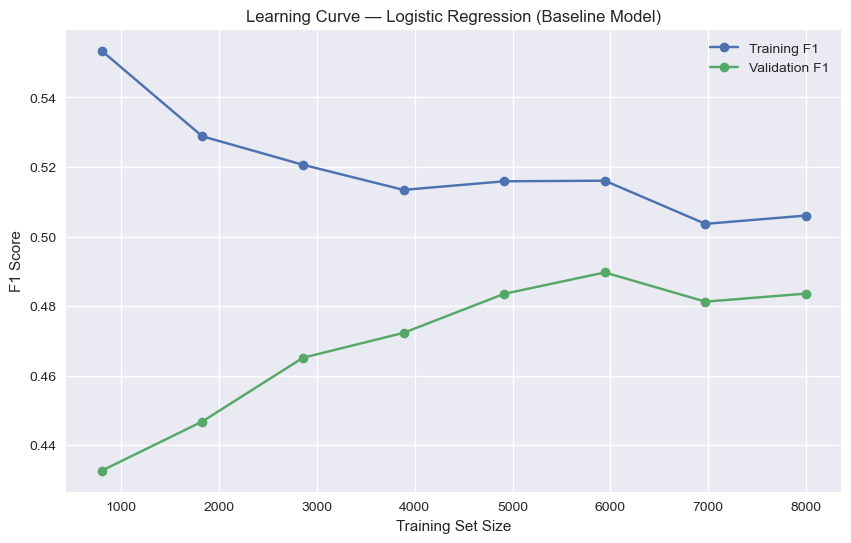

In [6]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    models['LogisticRegression'],
    X, y,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv=5,
    scoring='f1',
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training F1')
plt.plot(train_sizes, val_mean, 'o-', label='Validation F1')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.title('Learning Curve — Logistic Regression (Baseline Model)')
plt.grid(True)
plt.legend()
plt.show()

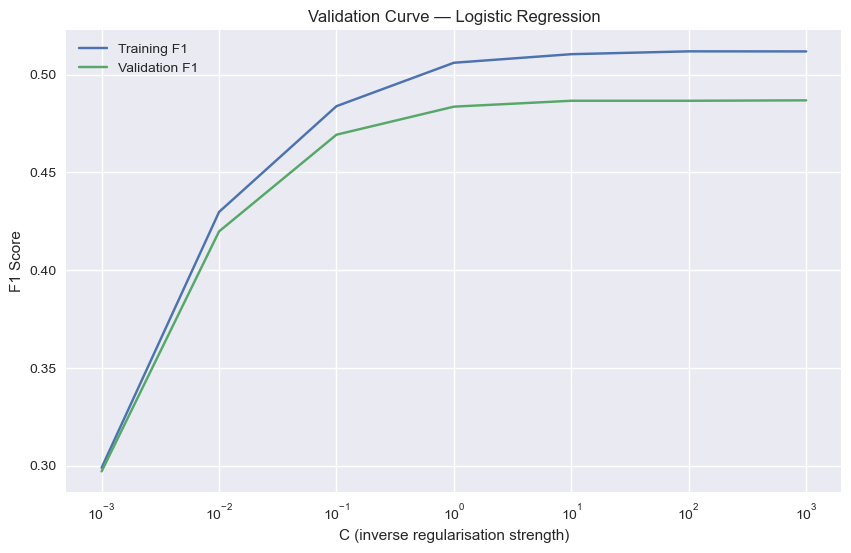

In [7]:
from sklearn.model_selection import validation_curve

param_range = np.logspace(-3, 3, 7)

train_scores, val_scores = validation_curve(
        models['LogisticRegression'],
    X, y,
    param_name='C',
    param_range=param_range,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

plt.figure(figsize=(10, 6))
plt.semilogx(param_range, train_scores.mean(axis=1), label="Training F1")
plt.semilogx(param_range, val_scores.mean(axis=1), label="Validation F1")
plt.xlabel('C (inverse regularisation strength)')
plt.ylabel('F1 Score')
plt.title('Validation Curve — Logistic Regression')
plt.grid(True)
plt.legend()
plt.show()

Average Precision (PR-AUC): 0.600
Area under PR-curve (by trapezoid): 0.600


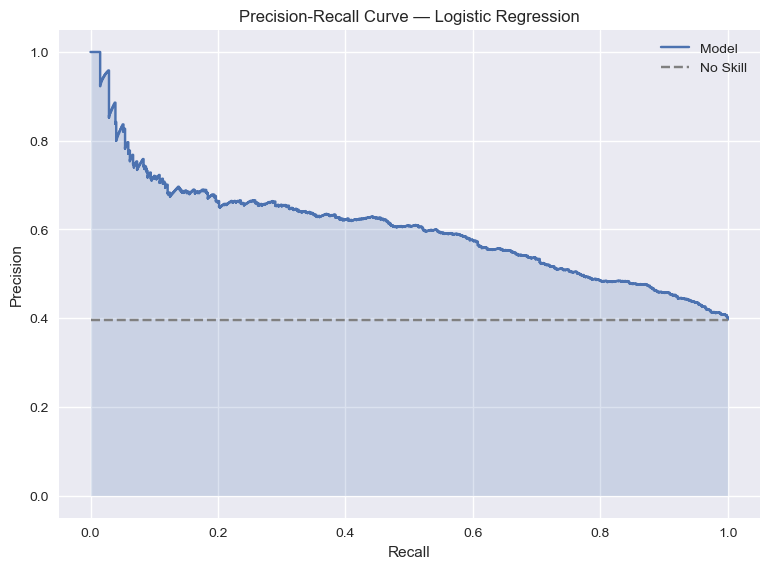

In [8]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
import matplotlib.pyplot as plt

model_choice = 'LogisticRegression'
# Assume:
#   y_test – the actual binary labels (0/1) for the test set
#   y_proba – the predicted probabilities for the positive class (model.predict_proba(X_test)[:,1])

# Compute precision/recall pairs for various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba[model_choice])

# Compute average precision (PR-AUC)
pr_auc = average_precision_score(y_test, y_proba[model_choice])

# Compute area under the precision-recall curve (alternate)
pr_auc_trap = auc(recall, precision)

print(f"Average Precision (PR-AUC): {pr_auc:.3f}")
print(f"Area under PR-curve (by trapezoid): {pr_auc_trap:.3f}")

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, where='post', label='Model')
plt.fill_between(recall, precision, step='post', alpha=0.2)

# Plot the no-skill line (precision equal to prevalence)
no_skill = sum(y_test==1) / len(y_test)
plt.hlines(no_skill, 0, 1, linestyle='--', color='grey', label='No Skill')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve — Logistic Regression')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Random Forest

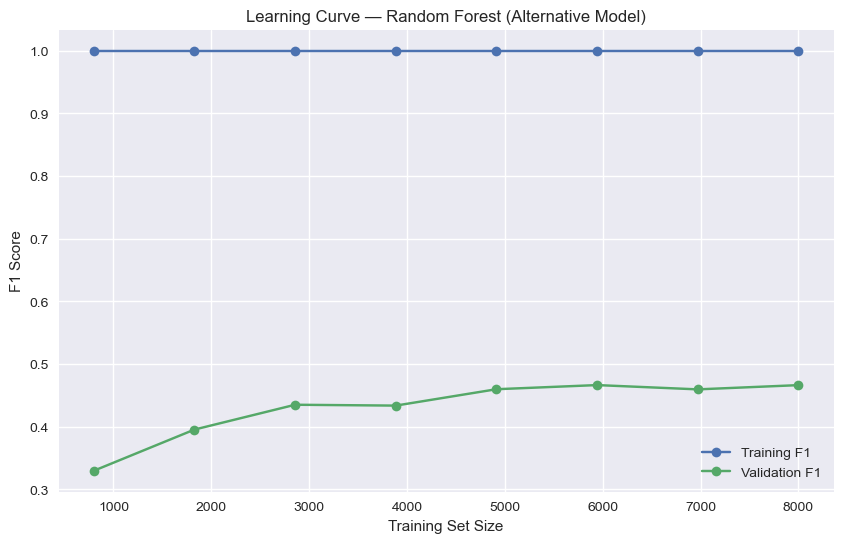

In [9]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    models['RandomForest'],
    X, y,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv=5,
    scoring='f1',
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training F1')
plt.plot(train_sizes, val_mean, 'o-', label='Validation F1')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.title('Learning Curve — Random Forest (Alternative Model)')
plt.grid(True)
plt.legend()
plt.show()

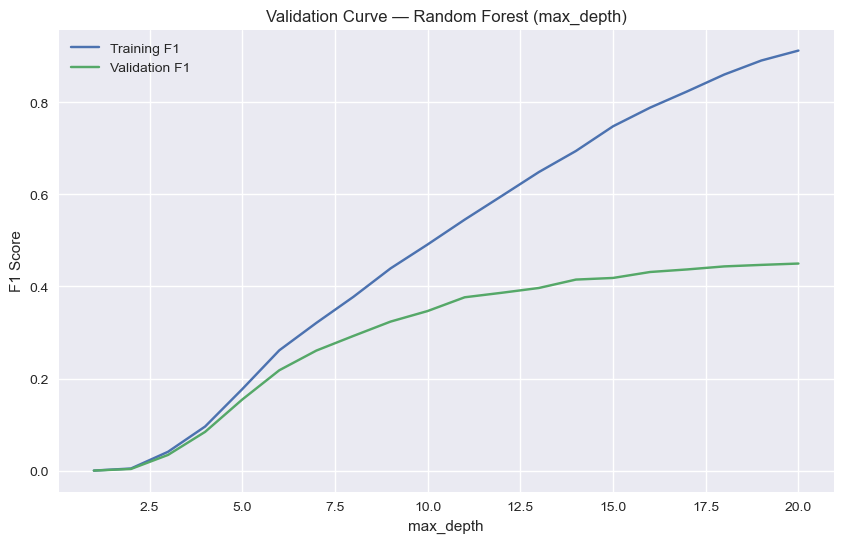

In [10]:
from sklearn.model_selection import validation_curve
import numpy as np
import matplotlib.pyplot as plt

param_range = np.arange(1, 21)

train_scores, val_scores = validation_curve(
    models['RandomForest'],
    X, y,
    param_name='max_depth',
    param_range=param_range,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

plt.figure(figsize=(10, 6))
plt.plot(param_range, train_scores.mean(axis=1), label='Training F1')
plt.plot(param_range, val_scores.mean(axis=1), label='Validation F1')
plt.xlabel('max_depth')
plt.ylabel('F1 Score')
plt.title('Validation Curve — Random Forest (max_depth)')
plt.grid(True)
plt.legend()
plt.show()

Average Precision (PR-AUC): 0.556
Area under PR-curve (by trapezoid): 0.557


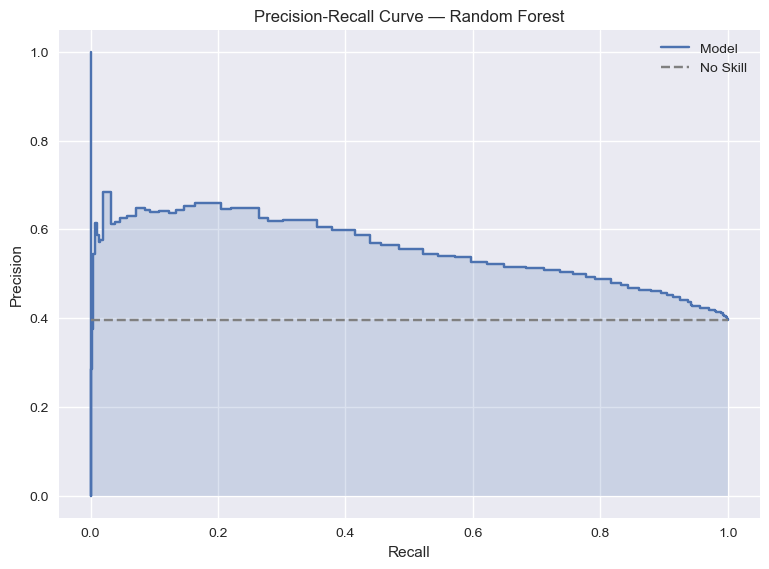

In [11]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
import matplotlib.pyplot as plt

model_choice = 'RandomForest'
# Assume:
#   y_test – the actual binary labels (0/1) for the test set
#   y_proba – the predicted probabilities for the positive class (model.predict_proba(X_test)[:,1])

# Compute precision/recall pairs for various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba[model_choice])

# Compute average precision (PR-AUC)
pr_auc = average_precision_score(y_test, y_proba[model_choice])

# Compute area under the precision-recall curve (alternate)
pr_auc_trap = auc(recall, precision)

print(f"Average Precision (PR-AUC): {pr_auc:.3f}")
print(f"Area under PR-curve (by trapezoid): {pr_auc_trap:.3f}")

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, where='post', label='Model')
plt.fill_between(recall, precision, step='post', alpha=0.2)

# Plot the no-skill line (precision equal to prevalence)
no_skill = sum(y_test==1) / len(y_test)
plt.hlines(no_skill, 0, 1, linestyle='--', color='grey', label='No Skill')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve — Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
import shap

In [13]:
background = shap.maskers.Independent(X_train, max_samples=1000)
explainer = shap.LinearExplainer(
    models['LogisticRegression'],
    X_train,
    feature_perturbation="interventional"
)
shap_values = explainer(X_test)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


### N.B. use this for Random Forest
explainer = shap.TreeExplainer(
    models['RandomForest'],
    feature_perturbation="tree_path_dependent"
)

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


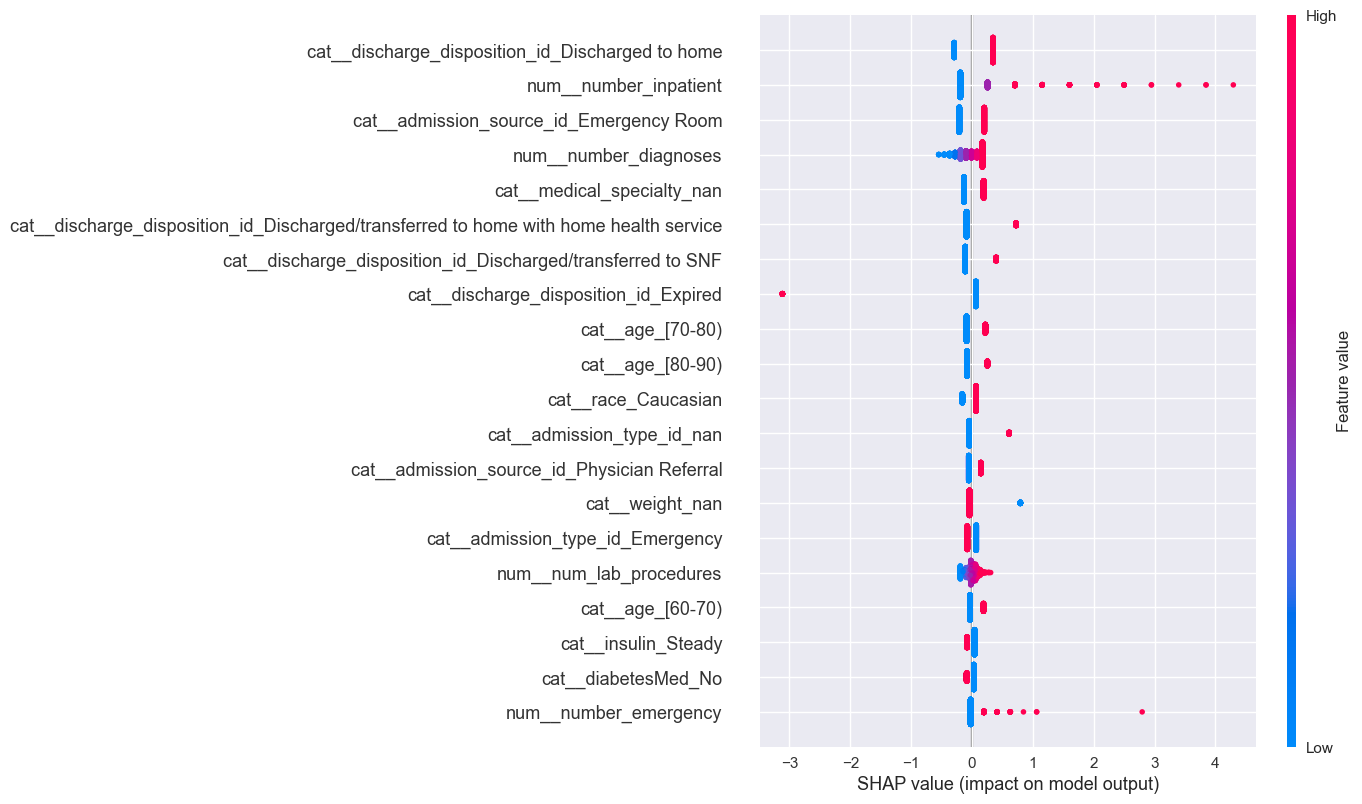

In [14]:
plt.tight_layout(pad=2.0)
shap.summary_plot(shap_values, X_test)

# Conclusion

### My Modelling Approach
- Examine data first -- specifically, look for missing data, and imbalance in the variable under prediction.
- Standard baseline models first (Logistic Regression, Random Forest).
- Random Forest overfit; raw ICD-9 expansion added no value without clinical grouping.
- SHAP - validates feature importance and plausibility.


### Key Predictors
- Prior inpatient and emergency visits were the strongest indicators of readmission risk.
- Discharge disposition and age bands also predictive .
- ICD-9 codes no use without time-intensive clinical grouping.


### How Hospitals Can Use This
- Identify high-risk patients for careful discharge planning and follow-through (social workers, community support).
- Focus resources to target signatures of patients likely to present for readmission.
- Flag high-risk discharge types (rehab, nursing-home, home-health, AMA) and automatically trigger extra follow-up checks to reduce readmissions.